# fastText Visualization

In this notebook I load in the pre-trained word vector model and perform some visualizations to check out how well our vector representation is performing.

In [11]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv, find_dotenv
import boto3
import re

In [6]:
load_dotenv(find_dotenv())

True

First we load in the word2vec model data

In [9]:
# whether to use ceph or store locally

use_ceph = True

if use_ceph:
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

In [12]:
pattern = re.compile('github-labeler/w2v/.*')

buck = boto3.resource(
    service_name="s3",
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
    endpoint_url=s3_endpoint_url,
)

keys = []

for obj in buck.Bucket(s3_bucket).objects.all():
    if pattern.match(obj.key):
        keys.append(obj.key)

keys = [os.path.basename(key) for key in keys]

In [13]:
if use_ceph:
    for key in keys:
        response = s3.get_object(
            Bucket=s3_bucket,
            Key=f"github-labeler/w2v/{key}",
        )
        with open(f'../models/{key}' ,'wb') as f:
            for i in response['Body']:
                f.write(i)

w = Word2Vec.load('../models/w2v.model')

Now we can see which words are close to one another. We can also put all of these words in a list and use TSNE to plot them in 2 dimensions.

In [32]:
example_words = [
    'jupyter',
    'python',
    'code',
    'error',
    'bug',
    'output',
    'linux',
    'kubernetes',
    'storage',
    'sql',
    'database']

all_words = example_words.copy()

for word in example_words:
    print(word)
    print('- - - -')
    similars = w.wv.most_similar(word, topn = 5)
    for s, a in similars:
        print('{:>25} {:>8}'.format(s, a))
        all_words.append(s)
    print('^ ^ ^ ^')

jupyter
- - - -
                   golang 0.9889159620626169
                   kotlin 0.9880805089923155
                      5.8 0.9876452827651078
                    2.5.1 0.9875426172534423
                manylinux 0.9874136032814658
^ ^ ^ ^
python
- - - -
                      php 0.9035140045617231
com.apple.diskarbitration 0.9013418809983986
                   pyhton 0.8965683839247657
                   5.10.1 0.8957583851565193
                installed 0.8949183111232709
^ ^ ^ ^
code
- - - -
           code/codewords 0.7595095609164155
                    codes 0.6996574498101593
                     zbar 0.6908011756327033
        install-extension 0.670614009853952
              selfhosting 0.6702730176516231
^ ^ ^ ^
error
- - - -
                exception 0.8349727766495274
                   errors 0.7797601649867978
                loaderror 0.7577024460847197
                unhandled 0.7366842113842693
                   failed 0.7335032621008353
^ ^ ^ ^
bug
- - - -

We see that the pre-training taught our model a lot about these technical terms. Almost every similar pair we know to indeed be very closely related.

In [33]:
vectors = [w.wv[word] for word in all_words]

reduced = TSNE().fit_transform(vectors)

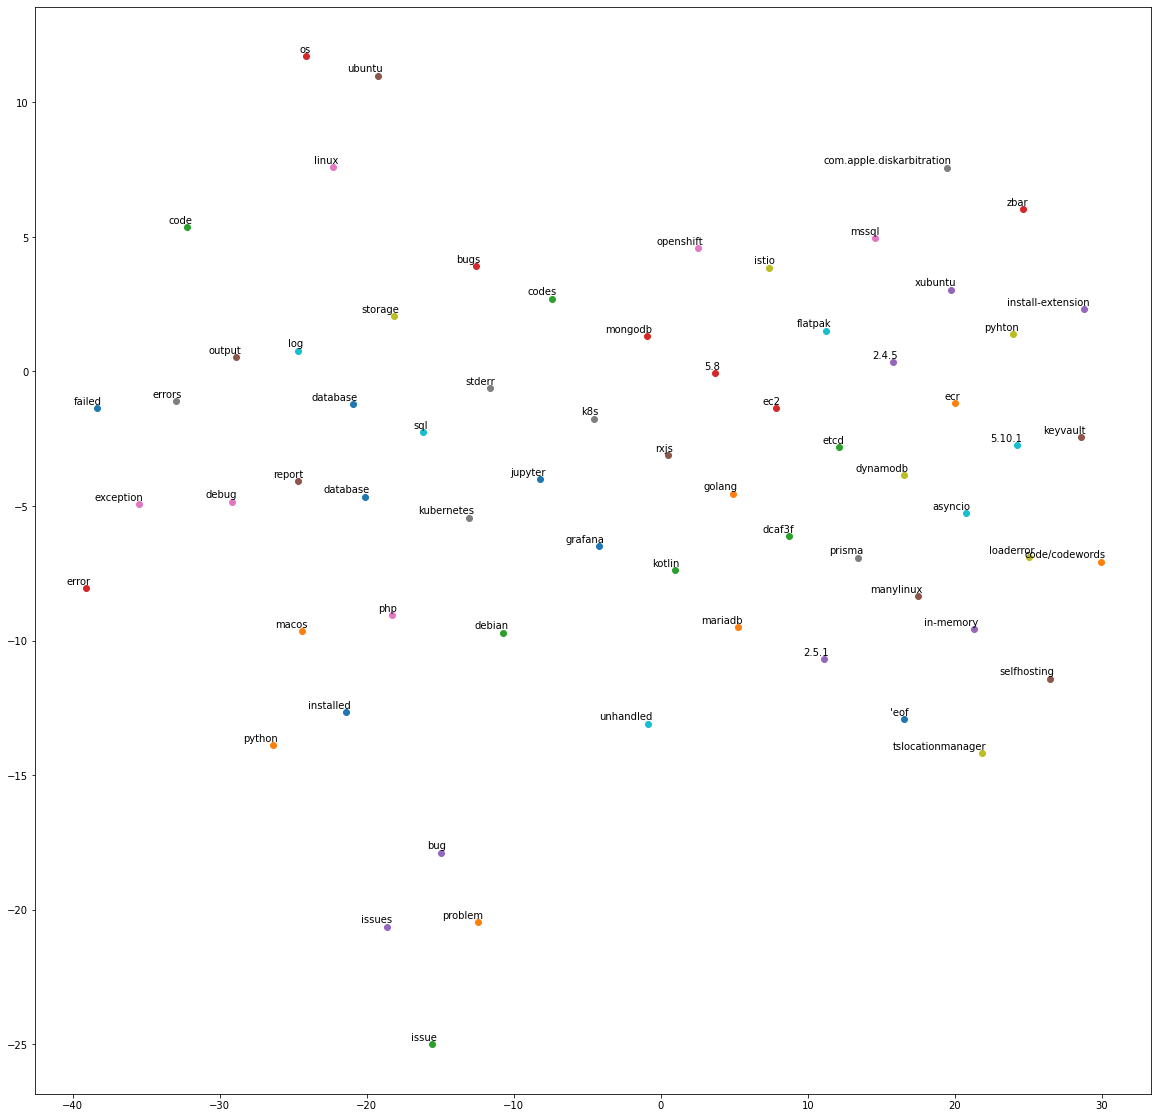

In [34]:
x = []
y = []
for value in reduced:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(20, 20))
for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.annotate(
        all_words[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords="offset points",
        ha="right",
        va="bottom",
    )

Using this plot one can see how close certain words are to each other, in some sense. This plot is not too interesting to look at since we chose the examples artificially by coming up with some common code lingo and adding in it's synonyms. However, using this basic framework of applying TSNE to 2-dimensionalize the data many other visualizations are possible such as visualizing the most common words in a repo, etc.